# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

Дальнейшие улучшения.

## Задачи

- *DONE* p=0, p=0.95, p=0.99, помимо 0.05 и 0.5
- *DONE* Поменьше выводить текстовых логов
- `TODO` Графики соединить через subplots: по одной сетке графики
  в рамках одной фигуры.
  - *DONE* Графики нескольких метрик валидации на одной фигуре
- `TODO` Раскомментировать параметры
- `TODO` `clear_output(wait=True)`
- `TODO` `plt.xscale('log')` ???


## Настройки

In [28]:
REPORT_DIR = "report/"

TEST_SAMPLE_SIZE = 0.2
ITERATIONS = 1 # 10
RANDOM_STATE = 23432
BATCH_SIZE = 12
EPOCHS = 1 # 10
LEARNING_RATE = 0.00011
PP = [0, 0.01, 0.05, 0.5, 0.9, 0.95, 0.99]
PRINT_TRAINING_SPAN = 500

NOISE_SAMPLES_COUNT = 50
NOISE_FACTORS = [
    x * 2/NOISE_SAMPLES_COUNT for x in range(NOISE_SAMPLES_COUNT)
]

In [29]:
pip install torch torchvision pandas scikit-learn 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Генерация отчёта

In [30]:
import os
import json
import torch

if not os.path.exists(REPORT_DIR):
    os.makedirs(REPORT_DIR)

report_data = {}

def append_to_report(label, data):
    report_data[label] = data

def save_report():
    path = os.path.join(REPORT_DIR, 'report.json')
    with open(path, 'w') as file:
        json.dump(report_data, file, indent=4)
    print(f"Отчёт сохранён в {path}")

## Данные

In [31]:
import torch
import torch.nn as nn
from dataclasses import dataclass

@dataclass
class LearningTask:
    criterion: object
    dtype: torch.dtype

CLASSIFICATION_TASK = LearningTask(
    criterion=nn.CrossEntropyLoss(),
    dtype=torch.long
)

REGRESSION_TASK = LearningTask(
    criterion=nn.MSELoss(),
    dtype=torch.float
)

In [32]:
from typing import List, Tuple

import urllib.request
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

def download_csv(
    url: str,
    saved_name: str,
    features: List[str] = None
) -> pd.DataFrame:
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    file_path = os.path.join(data_dir, saved_name)

    urllib.request.urlretrieve(url, file_path)

    if features is None:
        return pd.read_csv(file_path)
    else:
        return pd.read_csv(file_path, header=None, names=features)

def tensor_dataset_from_dataframe(
    df: pd.DataFrame,
    target: str,
    y_dtype: type
) -> TensorDataset:
    X = df.drop(columns=[target]).values
    y = df[target].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=y_dtype)

    return TensorDataset(X_tensor, y_tensor)

In [33]:
def breast_cancer_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/dataspelunking/MLwR/refs/heads/master/Machine%20Learning%20with%20R%20(2nd%20Ed.)/Chapter%2003/wisc_bc_data.csv',
        saved_name='wisc_bc_data.csv'
    )

    target = 'diagnosis'

    df[target] = df[target].map({ 'M': 0, 'B': 1 })
    df = df.drop(columns=['id'])

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        tensor_dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        ),
        tensor_dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        )
    )

In [34]:
def car_evaluation_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/mragpavank/car-evaluation-dataset/refs/heads/master/car_evaluation.csv',
        saved_name='car_evaluation.csv',
        features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    )

    target = 'class'

    df[target] = df[target].map({
        'unacc': 0,
        'acc': 1,
        'good': 2,
        'vgood': 3,
    })

    df['doors'] = df['doors'].map({
        '2': 2,
        '3': 3,
        '4': 4,
        '5more': 5
    })

    high_map = {
        'low': 0,
        'med': 1,
        'high': 2,
        'vhigh': 3
    }

    df['buying'] = df['buying'].map(high_map)
    df['safety'] = df['safety'].map(high_map)
    df['maint'] = df['maint'].map(high_map)

    df['persons'] = df['persons'].map({
        '2': 2,
        '4': 4,
        'more': 6
    })

    df['lug_boot'] = df['lug_boot'].map({
        'small': 0,
        'med': 1,
        'big': 2
    })

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )
    return (
        tensor_dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        ),
        tensor_dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        )
    )

In [35]:

def student_performance_factors_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = pd.read_csv('data/StudentPerformanceFactors.csv')

    target = 'Exam_Score'

    lmh = {
        'Low': -1,
        'Medium': 0,
        'High': +1,
    }

    yn = {
        'Yes': +1,
        'No': -1,
    }

    df = df.dropna(subset=['Teacher_Quality'])

    df['Parental_Involvement'] = df['Parental_Involvement'].map(lmh)
    df['Access_to_Resources'] = df['Access_to_Resources'].map(lmh)
    df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yn)
    df['Motivation_Level'] = df['Motivation_Level'].map(lmh)
    df['Internet_Access'] = df['Internet_Access'].map(yn)
    df['Family_Income'] = df['Family_Income'].map(lmh)
    df['Teacher_Quality'] = df['Teacher_Quality'].map(lmh)
    df['School_Type'] = df['School_Type'].map({
        'Public': +1,
        'Private': -1,
    })
    df['Peer_Influence'] = df['Peer_Influence'].map({
        'Positive': +1,
        'Neutral': 0,
        'Negative': -1,
    })
    df['Learning_Disabilities'] = df['Learning_Disabilities'].map(yn)
    df['Parental_Education_Level'] = df['Parental_Education_Level'].map({
        'Postgraduate': +3,
        'College': +2,
        'High School': +1,
    }).fillna(0)
    df['Distance_from_Home'] = df['Distance_from_Home'].map({
        'Near': +1,
        'Moderate': 0,
        'Far': -1,
    }).fillna(0)
    df['Gender'] = df['Gender'].map({
        'Female': +1,
        'Male': -1,
    }).fillna(0)

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        tensor_dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=REGRESSION_TASK.dtype
        ),
        tensor_dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=REGRESSION_TASK.dtype
        )
    )

In [36]:
from dataclasses import dataclass

import pandas as pd
from torch.utils.data import DataLoader

@dataclass
class ExperimentParameters:
    iteration: int
    p: float

@dataclass
class DatasetData:
    train_dataset: pd.DataFrame
    test_dataset: pd.DataFrame
    train_loader: DataLoader
    test_loader: DataLoader

@dataclass
class Dataset:
    name: str
    number: int
    features_count: int
    classes_count: int
    data: DatasetData

    def model_a_path(self, params: ExperimentParameters) -> str:
        return f'report/model-{self.number}A-c-P{params.p}_N{params.iteration}.pth'

    def model_b_path(self, params: ExperimentParameters) -> str:
        return f'report/model-{self.number}B-c-P{params.p}_N{params.iteration}.pth'

In [37]:

from torch.utils.data import DataLoader

def make_dataset1(batch_size: int) -> Dataset:
    train_dataset, test_dataset = breast_cancer_dataset()

    return Dataset(
        name='wisc_bc_data.csv',
        number=1,
        features_count=train_dataset[1][0].shape[0],
        classes_count=2,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset2(batch_size: int) -> Dataset:
    train_dataset, test_dataset = car_evaluation_dataset()

    return Dataset(
        name='car_evaluation.csv',
        number=2,
        features_count=train_dataset[1][0].shape[0],
        classes_count=4,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset3(batch_size: int) -> Dataset:
    train_dataset, test_dataset = student_performance_factors_dataset()

    return Dataset(
        name='StudentPerformanceFactors.csv',
        number=3,
        features_count=train_dataset[1][0].shape[0],
        classes_count=1,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

datasets = [
    make_dataset1(batch_size=12),
    make_dataset2(batch_size=12),
    make_dataset3(batch_size=12),
]


## Модели

In [38]:
import torch

class CustomBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для линейного слоя.
    """
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias

class CustomReLUBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для слоя ReLU.
    """
    @staticmethod
    def forward(ctx, p: float, input: torch.Tensor):
        ctx.save_for_backward(torch.scalar_tensor(p), input)
        return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input = ctx.saved_tensors

        grad_output = grad_output * (input > 0).float()

        # У матриц ось 0 это Y
        height = grad_output.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        diagonal_mask = diagonal_mask.unsqueeze(1).expand(-1, grad_output.size(1), -1)
        diagonal_mask = diagonal_mask.permute(0, 2, 1)

        grad_output = grad_output.unsqueeze(1) * diagonal_mask
        grad_output = grad_output.sum(dim=1)

        return None, grad_output

    
class CustomReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, p: float):
        ctx.save_for_backward(input, torch.scalar_tensor(p))
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, p, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0

        # У матриц ось 0 это Y
        bernoulli_mask = torch.bernoulli(torch.ones(grad_input.size(0)) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item()+1e-5)
        
        # Multiply grad_input with the diagonal matrix
        grad_input = diagonal_mask @ grad_input
        
        return grad_input, None
    
    
class CustomReLULayer(torch.nn.Module):
    def __init__(self, p: float):
        super(CustomReLULayer, self).__init__()
        self.p = p
        self.custom_relu_backward = CustomReLUFunction.apply

    def forward(self, x):
        return self.custom_relu_backward(x, self.p)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class RegularNetwork(nn.Module):
    """
    Нейросеть с обычными линейными слоями. Параметр `p` игнорируется.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(RegularNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class AugmentedLinearNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для линейных слоёв.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.p = p

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(self.p, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(self.p, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class AugmentedReLUNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для функции активации.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_relu1 = CustomReLULayer(p)
        self.custom_relu2 = CustomReLULayer(p)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.custom_relu1(x)
        x = self.fc2(x)
        x = self.custom_relu2(x)
        x = self.fc3(x)
        return x



## Сохранение графиков

## Обучение

In [40]:
import torch

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())

In [41]:

import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn.init as init

from dataclasses import dataclass

@dataclass
class TrainingParameters:
    dataset: Dataset
    criterion: nn.CrossEntropyLoss | nn.MSELoss
    experiment_params: ExperimentParameters
    model_a_path: str
    model_b_path: str

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def print_progress(
    p: float,
    iteration: int,
    epoch: int,
    total_epochs: int,
    sample: int,
    total_samples: int,
    running_loss: float
):
    print(
        f'p={p} N={iteration} E{epoch}/{total_epochs} S{sample}/{total_samples} Loss={running_loss / 100:.4f}'
    )

def train(
    model, 
    dataset: Dataset,
    epochs: int,
    experiment_parameters: ExperimentParameters,
    criterion,
    optimizer
) -> list[float]:
    running_losses: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(dataset.data.train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % PRINT_TRAINING_SPAN == 0:
                print_progress(
                    p=experiment_parameters.p,
                    iteration=experiment_parameters.iteration,
                    epoch=epoch + 1,
                    total_epochs=epochs,
                    sample=i + 1,
                    total_samples=len(dataset.data.train_loader),
                    running_loss=running_loss
                )

            running_losses.append(running_loss)
            running_loss = 0.0
    
    return running_losses

def save_plot(filename_without_extension: str) -> str:
    path = os.path.join(REPORT_DIR, f'{filename_without_extension}.png')
    plt.savefig(path)
    plt.close()
    return path

def plot_loss_curve(
    model_name: str,
    dataset_name: str,
    dataset_number: int,
    running_losses: list[float],
    p: float,
    iteration: int,
):
    X = range(len(running_losses))
    
    plt.figure(figsize=(10, 6))
    plt.plot(X, running_losses, label='Running loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'Loss curve: {model_name} on {dataset_name} (#{dataset_number}), p = {p}, N = {iteration}')
    plt.legend()



In [42]:
def iterate_experiment_parameters():
    for iteration in range(0, ITERATIONS):
        for p in PP:
            yield ExperimentParameters(iteration, p)

p=0 N=0 E1/1 S1/38 Loss=0.0675
p=0 N=0 E1/1 S1/38 Loss=0.1004
Saving figure to report/loss_AugmentedReLUNetwork_1_p0_N0.png...
p=0 N=0 E1/1 S1/116 Loss=0.0137
p=0 N=0 E1/1 S1/116 Loss=0.0135
Saving figure to report/loss_AugmentedReLUNetwork_2_p0_N0.png...
p=0 N=0 E1/1 S1/436 Loss=45.7659


/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


p=0 N=0 E1/1 S1/436 Loss=48.5662
Saving figure to report/loss_AugmentedReLUNetwork_3_p0_N0.png...
p=0.01 N=0 E1/1 S1/38 Loss=0.1618
p=0.01 N=0 E1/1 S1/38 Loss=0.0664
Saving figure to report/loss_AugmentedReLUNetwork_1_p0.01_N0.png...
p=0.01 N=0 E1/1 S1/116 Loss=0.0131
p=0.01 N=0 E1/1 S1/116 Loss=0.0160
Saving figure to report/loss_AugmentedReLUNetwork_2_p0.01_N0.png...
p=0.01 N=0 E1/1 S1/436 Loss=49.1145
p=0.01 N=0 E1/1 S1/436 Loss=56.3933
Saving figure to report/loss_AugmentedReLUNetwork_3_p0.01_N0.png...
p=0.05 N=0 E1/1 S1/38 Loss=0.0511
p=0.05 N=0 E1/1 S1/38 Loss=0.1205
Saving figure to report/loss_AugmentedReLUNetwork_1_p0.05_N0.png...
p=0.05 N=0 E1/1 S1/116 Loss=0.0166
p=0.05 N=0 E1/1 S1/116 Loss=0.0141
Saving figure to report/loss_AugmentedReLUNetwork_2_p0.05_N0.png...
p=0.05 N=0 E1/1 S1/436 Loss=39.0231
p=0.05 N=0 E1/1 S1/436 Loss=44.7771
Saving figure to report/loss_AugmentedReLUNetwork_3_p0.05_N0.png...
p=0.5 N=0 E1/1 S1/38 Loss=0.1684
p=0.5 N=0 E1/1 S1/38 Loss=0.0258
Saving f

/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_40680/3997776601.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Saving figure to report/loss_AugmentedReLUNetwork_2_p0.99_N0.png...
p=0.99 N=0 E1/1 S1/436 Loss=39.7891
p=0.99 N=0 E1/1 S1/436 Loss=45.1769
Saving figure to report/loss_AugmentedReLUNetwork_3_p0.99_N0.png...


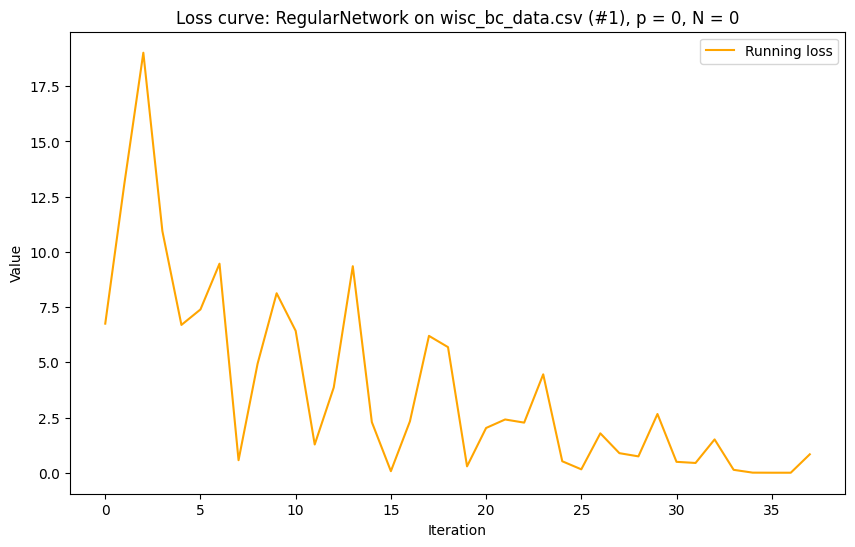

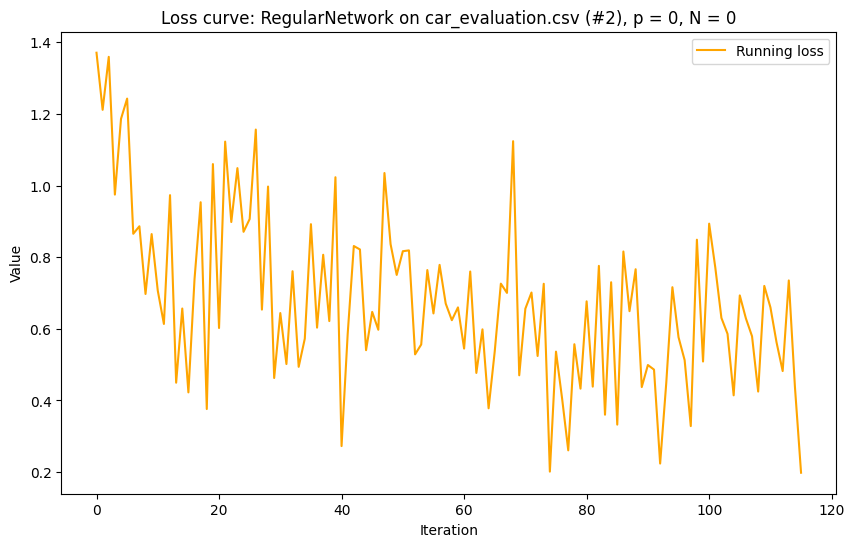

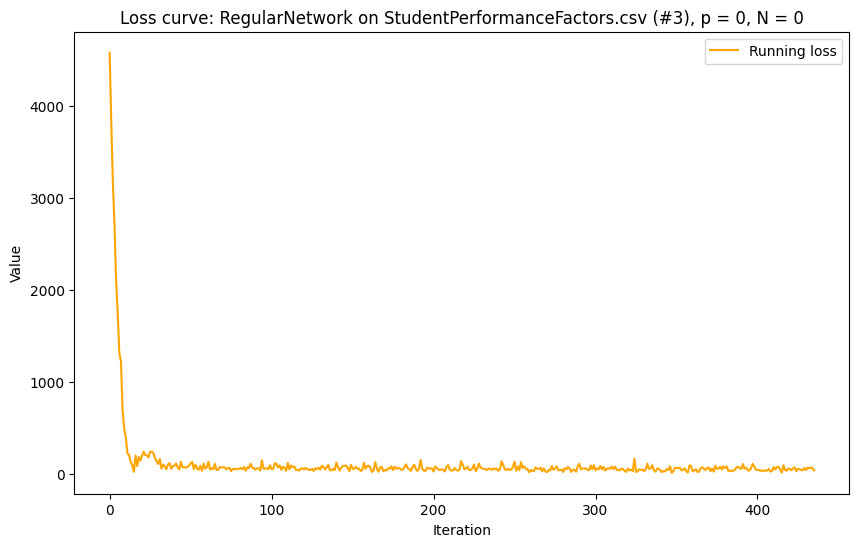

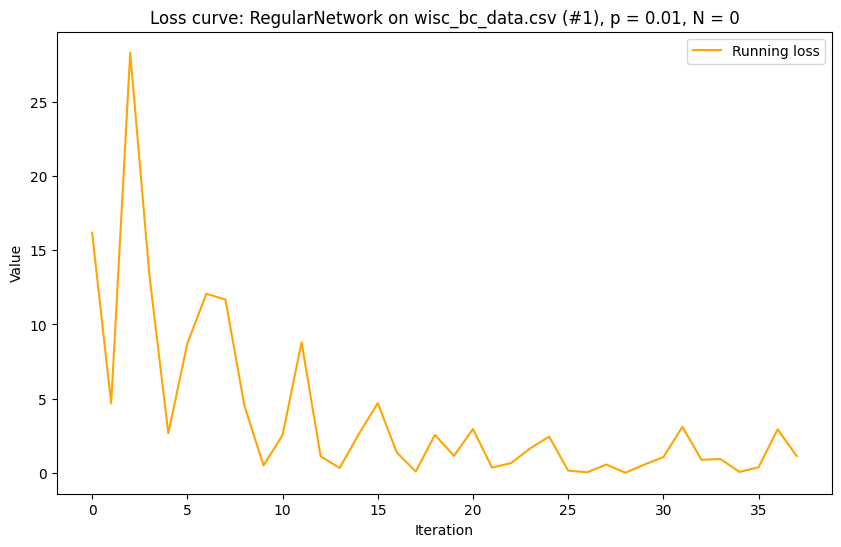

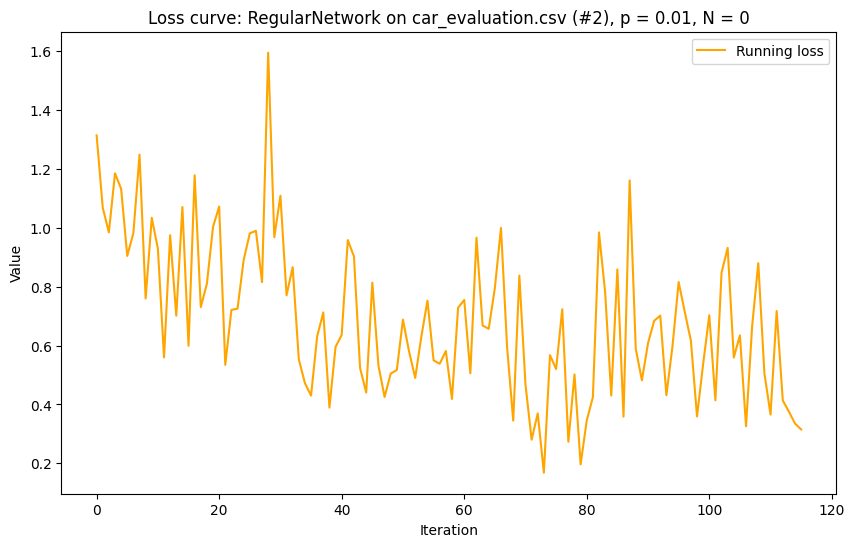

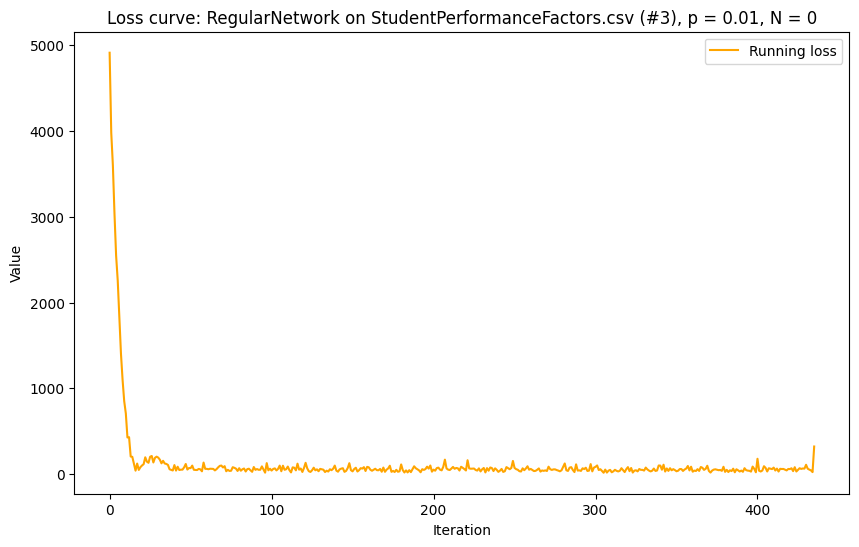

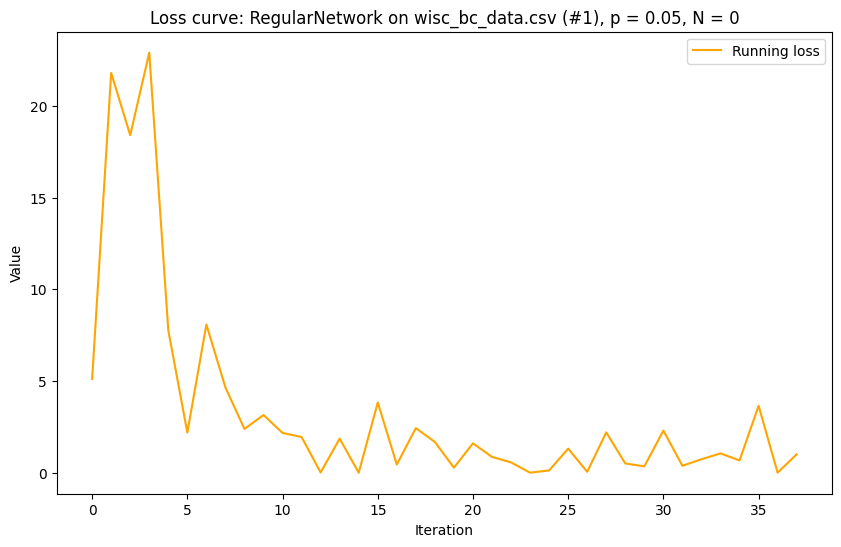

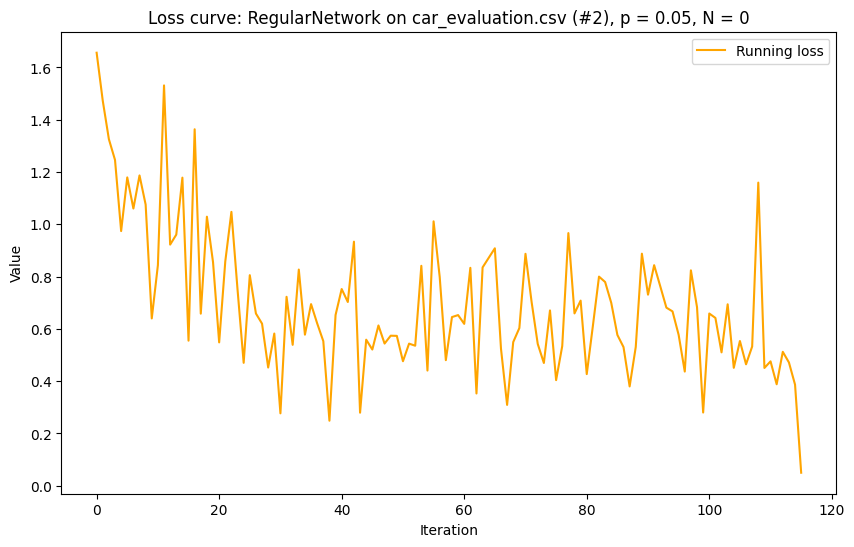

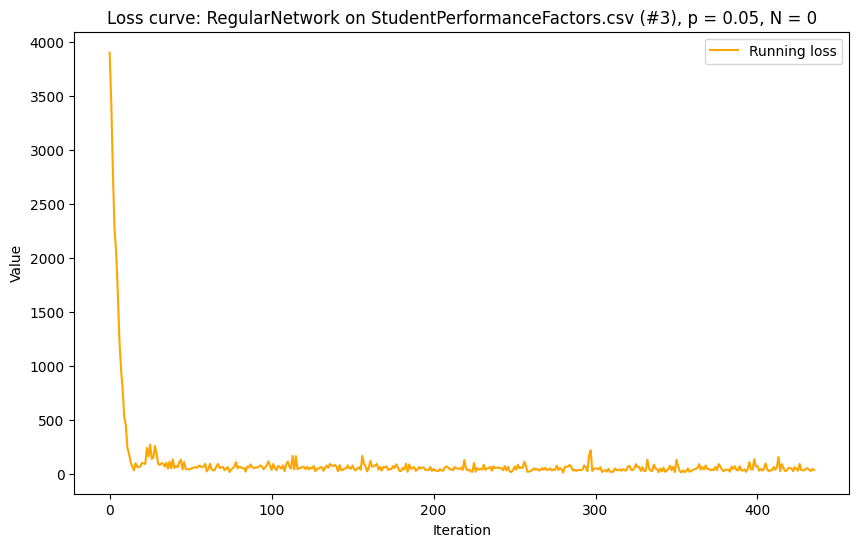

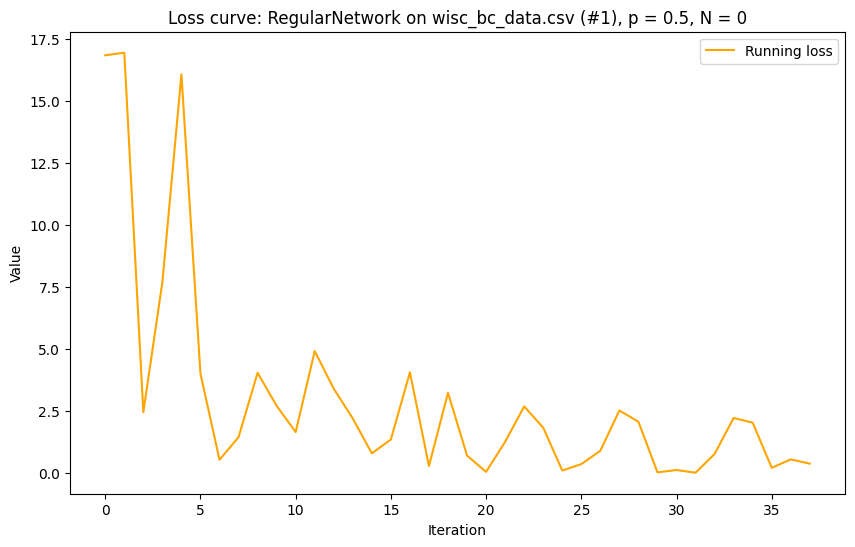

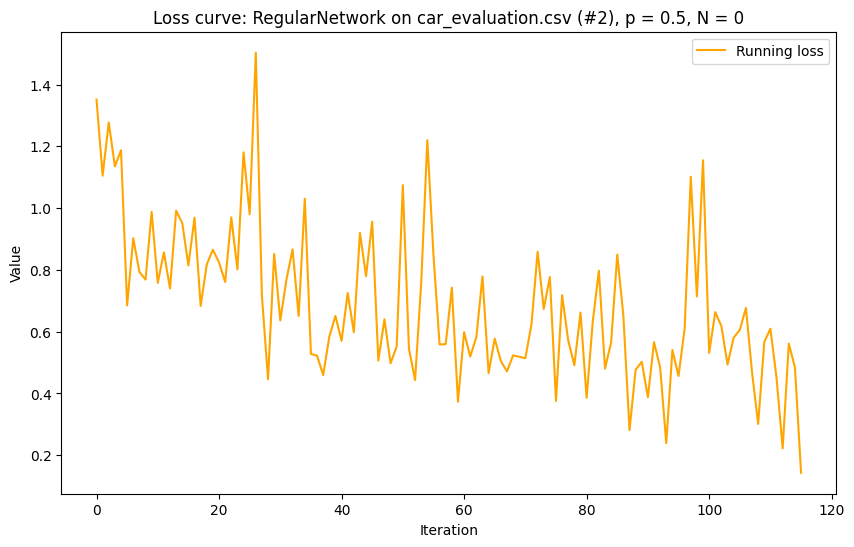

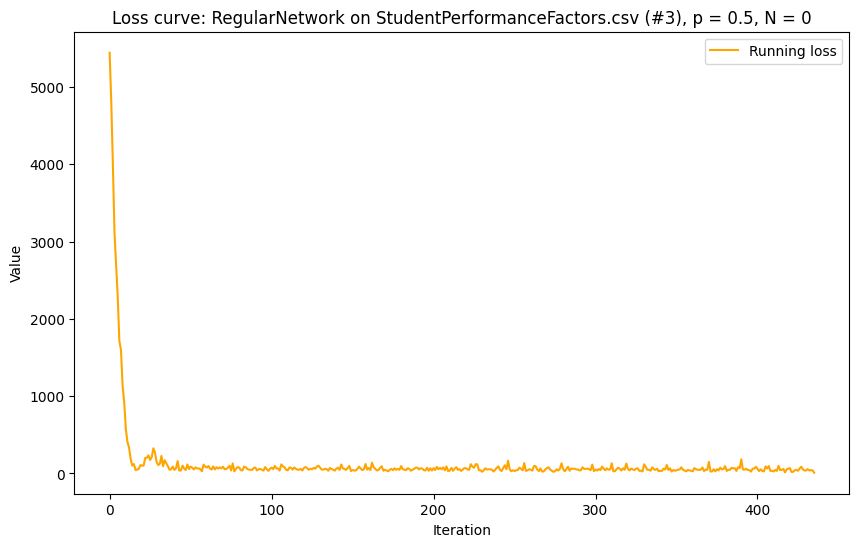

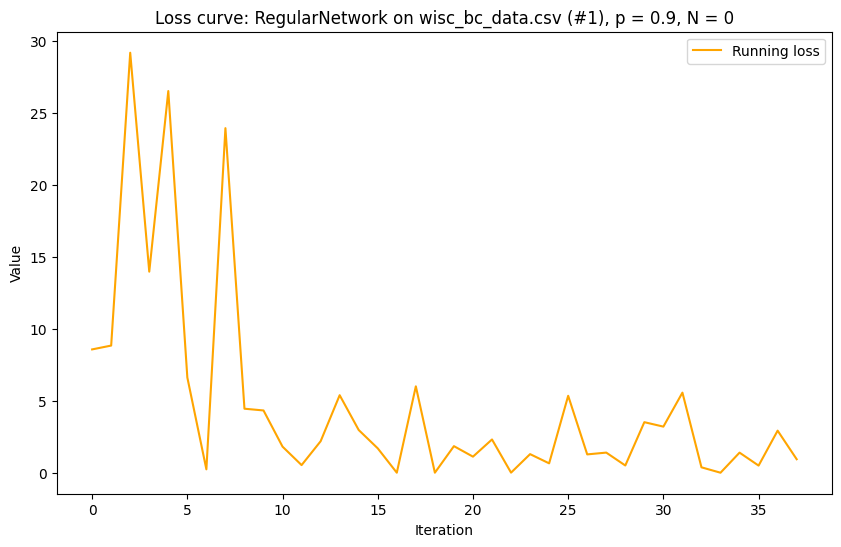

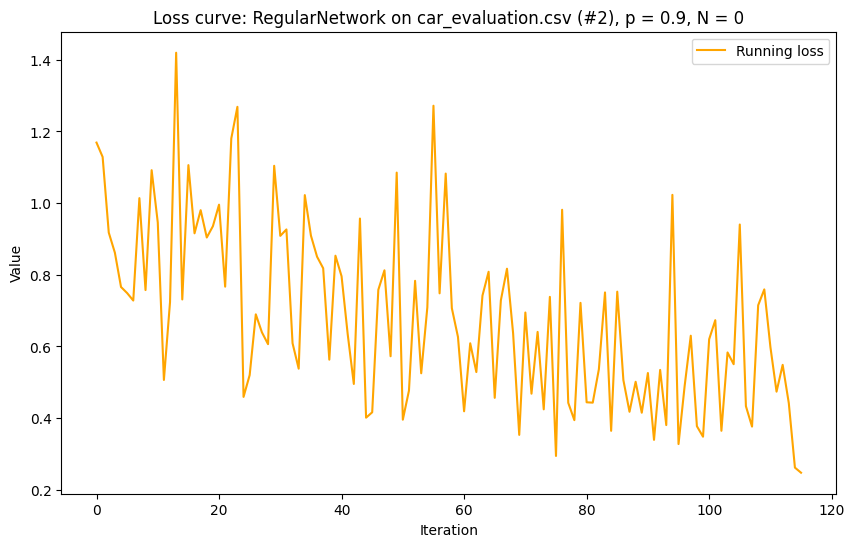

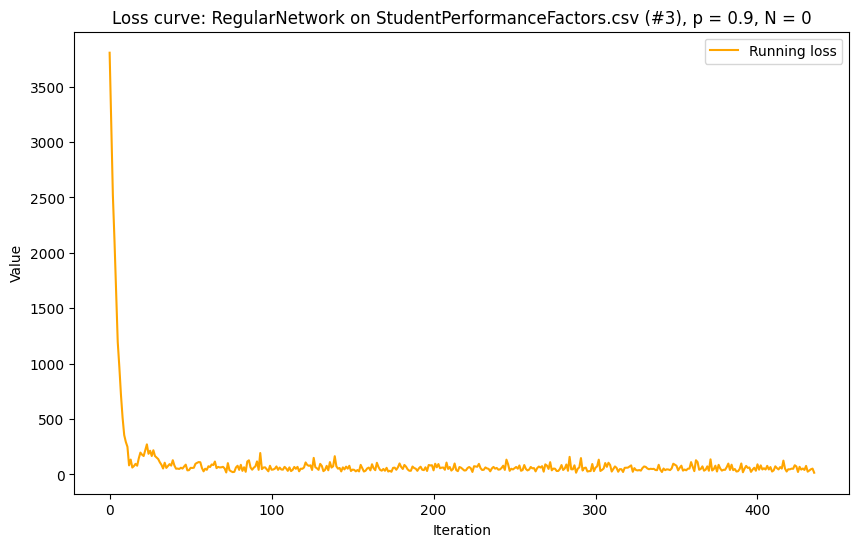

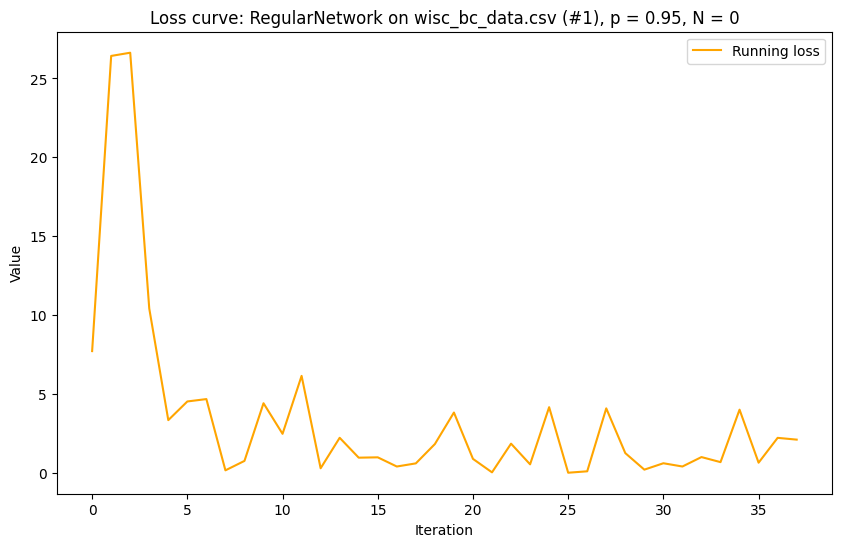

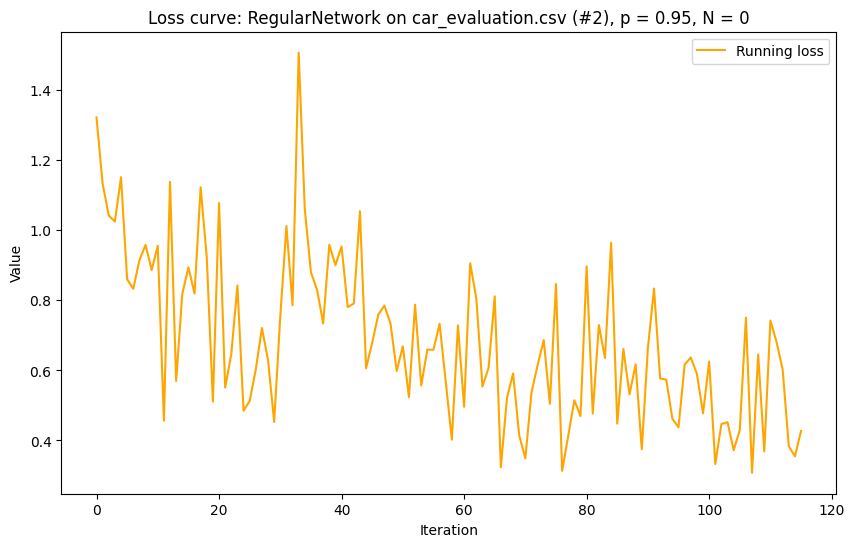

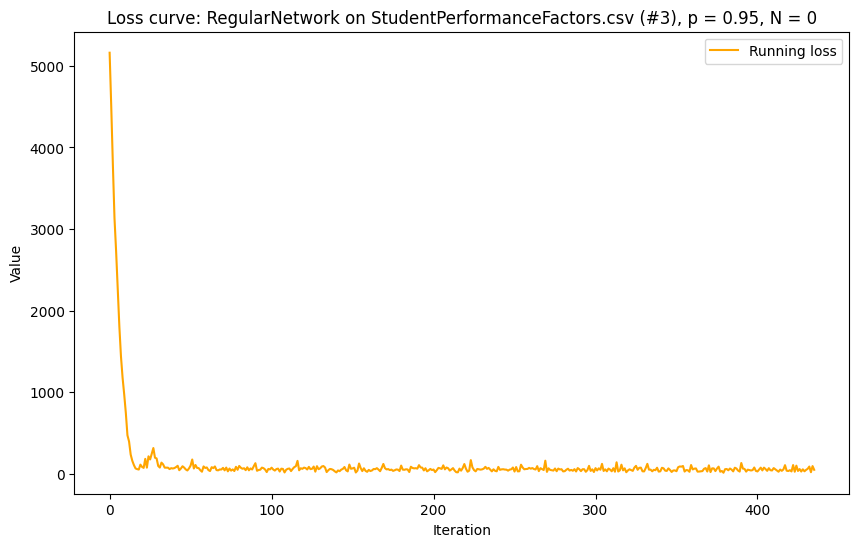

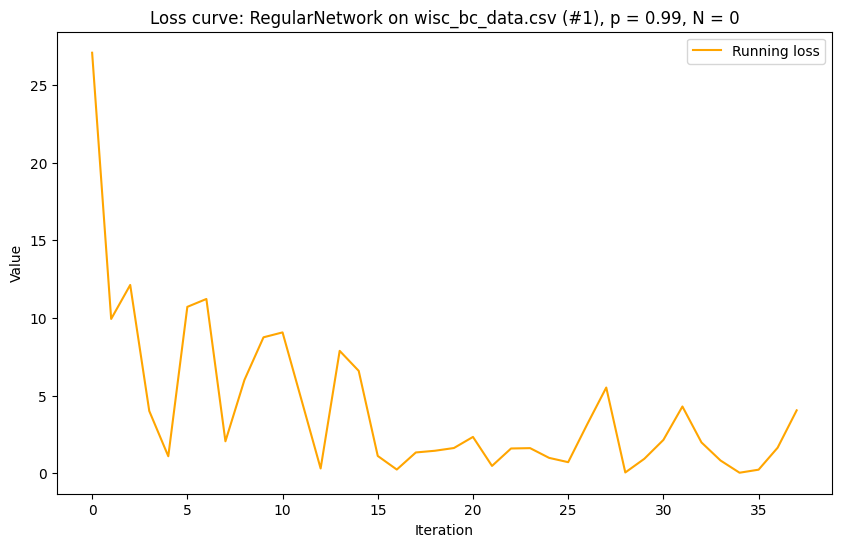

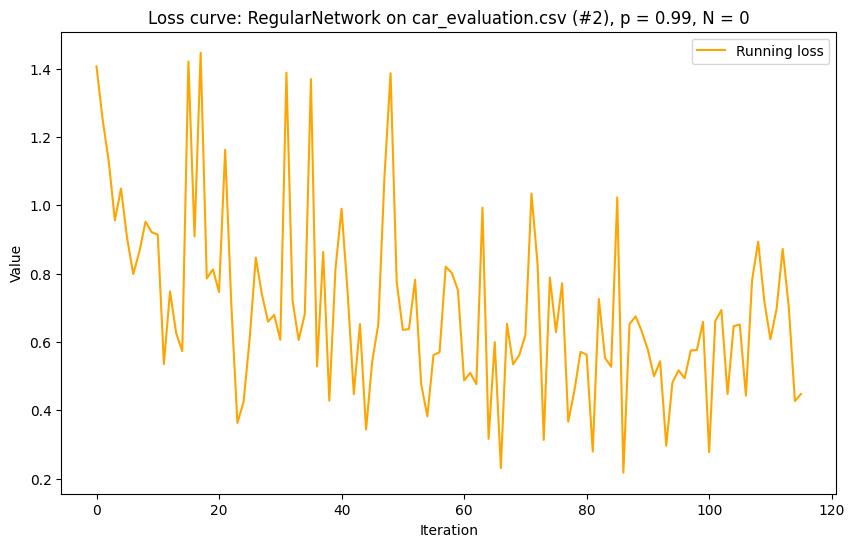

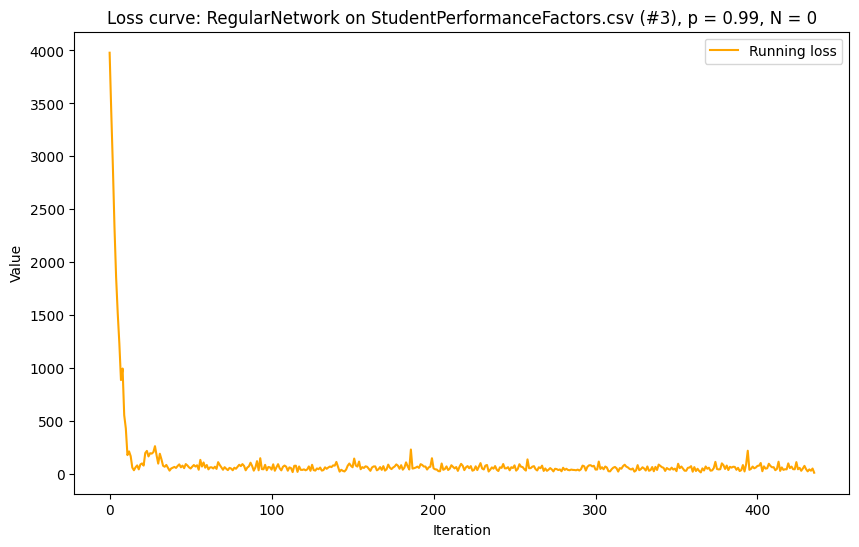

In [43]:

for experiment_params in iterate_experiment_parameters():
    for training_params in [
        TrainingParameters(
            dataset=datasets[0],
            criterion=CLASSIFICATION_TASK.criterion,
            experiment_params=experiment_params,
            model_a_path=datasets[0].model_a_path(experiment_params),
            model_b_path=datasets[0].model_b_path(experiment_params),
        ),
        TrainingParameters(
            dataset=datasets[1],
            criterion=CLASSIFICATION_TASK.criterion,
            experiment_params=experiment_params,
            model_a_path=datasets[1].model_a_path(experiment_params),
            model_b_path=datasets[1].model_b_path(experiment_params),
        ),
        TrainingParameters(
            dataset=datasets[2],
            criterion=REGRESSION_TASK.criterion,
            experiment_params=experiment_params, 
            model_a_path=datasets[2].model_a_path(experiment_params),
            model_b_path=datasets[2].model_b_path(experiment_params),
        )
    ]:
        inputs_count = training_params.dataset.features_count
        outputs_count = training_params.dataset.classes_count
        
        for (model, name) in [
            (RegularNetwork(
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                p=experiment_params.p
            ), training_params.model_a_path),
            (AugmentedReLUNetwork(
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                p=experiment_params.p
            ), training_params.model_b_path)
        ]:
            model.apply(init_weights)
            
            running_losses = train(
                model=model,
                dataset=training_params.dataset,
                epochs=EPOCHS,
                experiment_parameters=experiment_params,
                criterion=training_params.criterion,
                optimizer=optim.Adam(
                    model.parameters(),
                    lr=LEARNING_RATE
                )
            )
            
            torch.save(model.state_dict(), name)
            
            report_key = f'loss_{type(model).__name__}_{training_params.dataset.number}_p{experiment_params.p}_N{experiment_params.iteration}'
            
            append_to_report(report_key, running_losses)
            
            plot_loss_curve(
                model_name=model.__class__.__name__,
                dataset_name=training_params.dataset.name,
                dataset_number=training_params.dataset.number,
                running_losses=running_losses,
                p=experiment_params.p,
                iteration=experiment_params.iteration
            )
    
        path = save_plot(report_key)
        print(f'Saving figure to {path}...')

In [44]:

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, r2_score, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def positive_probs_from(probs: torch.Tensor) -> list:
    return np.array(probs)[:, 0]

def eval_accuracy_f1_rocauc(
    evaluated_model: RegularNetwork,
    dataset: Dataset,
    noise_factor: float,
    is_binary_classification: bool,
) -> tuple[float, float, float]:
    evaluated_model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataset.data.test_loader:
            outputs = evaluated_model(
                inputs + torch.randn(inputs.shape) * noise_factor
            )
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if is_binary_classification:
        all_probs = np.array(all_probs)[:, 0]

    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return float(accuracy), float(f1), float(roc_auc)

def eval_r2_mse(
    evaluated_model: RegularNetwork,
    dataset: Dataset,
    noise_factor: float,
) -> tuple[float, float]:
    evaluated_model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataset.data.test_loader:
            noisy_inputs = inputs + torch.randn(inputs.shape) * noise_factor
            outputs = evaluated_model(noisy_inputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    r2 = r2_score(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)

    return float(r2), float(mse)

def evaluate_regression_model(
    evaluated_model: RegularNetwork,
    dataset: Dataset,
    report_key: str,
)-> pd.DataFrame:
    samples = {
        'noise_factor': NOISE_FACTORS,
        'r2': [],
        'mse': [],
    }

    for noise_factor in NOISE_FACTORS:
        r2, mse = eval_r2_mse(
            evaluated_model=evaluated_model,
            dataset=dataset,
            noise_factor=noise_factor,
        )

        samples['r2'].append(r2)
        samples['mse'].append(mse)

    append_to_report(report_key, samples)

    return pd.DataFrame(samples)

def evaluate_classification_model(
    evaluated_model: RegularNetwork,
    dataset: Dataset,
    report_key: str,
    is_binary_classification: bool,
)-> pd.DataFrame:
    samples = {
        'noise_factor': NOISE_FACTORS,
        'accuracy': [],
        'f1': [],
        'roc_auc': [],
    }

    for noise_factor in NOISE_FACTORS:
        accuracy, f1, roc_auc = eval_accuracy_f1_rocauc(
            evaluated_model=evaluated_model,
            dataset=dataset,
            noise_factor=noise_factor,
            is_binary_classification=is_binary_classification,
        )

        samples['accuracy'].append(accuracy)
        samples['f1'].append(f1)
        samples['roc_auc'].append(roc_auc)

    append_to_report(report_key, samples)

    return pd.DataFrame(samples)

def plot_evaluation_of_classification(df: pd.DataFrame, title: str, report_key: str):
    plt.figure(figsize=(10, 6))
    
    _, ax = plt.subplots(3, 1)

    ax[0].plot(df['noise_factor'], df['accuracy'], label='Accuracy', marker='o')
    # XXX AttributeError: 'Axes' object has no attribute 'xscale'
    # ax[0].set_xscale('log')
    ax[0].set_xlabel('Noise Factor')
    ax[0].set_ylabel('Metric Value')
    ax[0].set_title(f'{title}')
    ax[0].legend()
    ax[0].grid(True, which="both", ls="--")

    ax[1].plot(df['noise_factor'], df['f1'], label='F1 Score', marker='o')
    # ax[1].set_xscale('log')
    ax[1].set_xlabel('Noise Factor')
    ax[1].set_ylabel('Metric Value')
    ax[1].set_title(f'{title}')
    ax[1].legend()
    ax[1].grid(True, which="both", ls="--")

    ax[2].plot(df['noise_factor'], df['roc_auc'], label='ROC AUC', marker='o')
    # ax[2].set_xscale('log')
    ax[2].set_xlabel('Noise Factor')
    ax[2].set_ylabel('Metric Value')
    ax[2].set_title(f'{title}')
    ax[2].legend()
    ax[2].grid(True, which="both", ls="--")
    
    save_plot(f'{report_key}')

def plot_evaluation_of_regression(df: pd.DataFrame, title: str, report_key: str):
    plt.figure(figsize=(10, 6))
    
    _, ax = plt.subplots(2, 1, figsize=(10, 12))
    
    ax[0].plot(df['noise_factor'], df['mse'], label='Mean Square Error', marker='o')
    # ax[0].set_xscale('log')
    ax[0].set_xlabel('Noise Factor')
    ax[0].set_ylabel('Metric Value')
    ax[0].set_title(f'{title}')
    ax[0].legend()
    ax[0].grid(True, which="both", ls="--")

    ax[1].plot(df['noise_factor'], df['r2'], label='R^2', marker='o')
    # ax[1].set_xscale('log')
    ax[1].set_xlabel('Noise Factor')
    ax[1].set_ylabel('Metric Value')
    ax[1].set_title(f'{title}')
    ax[1].legend()
    ax[1].grid(True, which="both", ls="--")

    save_plot(f'{report_key}')

In [45]:

@dataclass
class EvaluationParameters:
    dataset: Dataset
    model_path: str
    is_binary_classification: bool
    is_regression: bool
    inputs_count: int
    outputs_count: int
    task: LearningTask
    experiment_parameters: ExperimentParameters
    report_key: str

def model_path_for(
    model_a_or_b: str,
    dataset: Dataset
):
    if model_a_or_b == 'A':
        return dataset.model_a_path(experiment_params)
    elif model_a_or_b == 'B':
        return dataset.model_b_path(experiment_params)
    else:
        raise TypeError('model_a_or_b must be A or B')

def evaluate(
    model_a_or_b: str,
    constructor: type,
    experiment_parameters: EvaluationParameters
):
    eval_params_items: list[EvaluationParameters] = [
        EvaluationParameters(
            dataset=datasets[0],
            model_path=model_path_for(model_a_or_b, datasets[0]),
            is_binary_classification=True,
            is_regression=False,
            inputs_count=30,
            outputs_count=2,
            task=CLASSIFICATION_TASK,
            experiment_parameters=experiment_parameters,
            report_key=f'evaluate_{constructor.__name__}_{datasets[0].number}_p{experiment_parameters.p}_N{experiment_parameters.iteration}',
        ),
        EvaluationParameters(
            dataset=datasets[1],
            model_path=model_path_for(model_a_or_b, datasets[1]),
            is_binary_classification=False,
            is_regression=False,
            inputs_count=6,
            outputs_count=4,
            task=CLASSIFICATION_TASK,
            experiment_parameters=experiment_parameters,
            report_key=f'evaluate_{constructor.__name__}_{datasets[1].number}_p{experiment_parameters.p}_N{experiment_parameters.iteration}',
        ),
        EvaluationParameters(
            dataset=datasets[2],
            model_path=model_path_for(model_a_or_b, datasets[2]),
            is_binary_classification=False,
            is_regression=True,
            inputs_count=19,
            outputs_count=1,
            task=REGRESSION_TASK,
            experiment_parameters=experiment_parameters,
            report_key=f'evaluate_{constructor.__name__}_{datasets[2].number}_p{experiment_parameters.p}_N{experiment_parameters.iteration}',
        ),
    ]

    for eval_params in eval_params_items:
        evaluated_model = constructor(
            inputs_count=eval_params.inputs_count,
            outputs_count=eval_params.outputs_count,
            p=experiment_parameters.p
        )

        print(f'Loading state dict at {eval_params.model_path}')
        evaluated_model.load_state_dict(torch.load(eval_params.model_path))

        plot_title = f'Evaluating {eval_params.model_path}: p = {eval_params.experiment_parameters.p}, N = {eval_params.experiment_parameters.iteration}'

        if eval_params.task == CLASSIFICATION_TASK:
            plot_evaluation_of_classification(
                df=evaluate_classification_model(
                    evaluated_model=evaluated_model,
                    dataset=eval_params.dataset,
                    report_key=eval_params.report_key,
                    is_binary_classification=eval_params.is_binary_classification
                ),
                title=plot_title,
                report_key=eval_params.report_key
            )
        elif eval_params.task == REGRESSION_TASK:
            plot_evaluation_of_regression(
                df=evaluate_regression_model(
                    evaluated_model=evaluated_model,
                    dataset=eval_params.dataset,
                    report_key=eval_params.report_key
                ),
                title=plot_title,
                report_key=eval_params.report_key
            )
        else:
            raise ValueError(f"Unknown task: {eval_params.task}")

for experiment_params in iterate_experiment_parameters():
    evaluate('A', RegularNetwork, experiment_params)
    evaluate('B', AugmentedReLUNetwork, experiment_params)

save_report()

Loading state dict at report/model-1A-c-P0_N0.pth
Loading state dict at report/model-2A-c-P0_N0.pth
Loading state dict at report/model-3A-c-P0_N0.pth
Loading state dict at report/model-1B-c-P0_N0.pth
Loading state dict at report/model-2B-c-P0_N0.pth
Loading state dict at report/model-3B-c-P0_N0.pth
Loading state dict at report/model-1A-c-P0.01_N0.pth
Loading state dict at report/model-2A-c-P0.01_N0.pth
Loading state dict at report/model-3A-c-P0.01_N0.pth
Loading state dict at report/model-1B-c-P0.01_N0.pth
Loading state dict at report/model-2B-c-P0.01_N0.pth
Loading state dict at report/model-3B-c-P0.01_N0.pth
Loading state dict at report/model-1A-c-P0.05_N0.pth
Loading state dict at report/model-2A-c-P0.05_N0.pth
Loading state dict at report/model-3A-c-P0.05_N0.pth
Loading state dict at report/model-1B-c-P0.05_N0.pth
Loading state dict at report/model-2B-c-P0.05_N0.pth
Loading state dict at report/model-3B-c-P0.05_N0.pth
Loading state dict at report/model-1A-c-P0.5_N0.pth
Loading stat

/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_40680/2964796814.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(3, 1)


Loading state dict at report/model-3A-c-P0.5_N0.pth


/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_40680/2964796814.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Loading state dict at report/model-1B-c-P0.5_N0.pth
Loading state dict at report/model-2B-c-P0.5_N0.pth
Loading state dict at report/model-3B-c-P0.5_N0.pth
Loading state dict at report/model-1A-c-P0.9_N0.pth
Loading state dict at report/model-2A-c-P0.9_N0.pth
Loading state dict at report/model-3A-c-P0.9_N0.pth
Loading state dict at report/model-1B-c-P0.9_N0.pth
Loading state dict at report/model-2B-c-P0.9_N0.pth
Loading state dict at report/model-3B-c-P0.9_N0.pth
Loading state dict at report/model-1A-c-P0.95_N0.pth
Loading state dict at report/model-2A-c-P0.95_N0.pth
Loading state dict at report/model-3A-c-P0.95_N0.pth
Loading state dict at report/model-1B-c-P0.95_N0.pth
Loading state dict at report/model-2B-c-P0.95_N0.pth
Loading state dict at report/model-3B-c-P0.95_N0.pth
Loading state dict at report/model-1A-c-P0.99_N0.pth
Loading state dict at report/model-2A-c-P0.99_N0.pth
Loading state dict at report/model-3A-c-P0.99_N0.pth
Loading state dict at report/model-1B-c-P0.99_N0.pth
Lo

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>